Original Dataset:
    House Size  Num Bedrooms  Year Built    House Price
0         2126             2        2006  213397.461499
1         2459             4        2021  275174.398210
2         1860             3        2007  200910.340013
3         2294             2        1995  227644.402597
4         2130             3        1994  212184.478053
5         2095             3        1982  214882.446136
6         2724             3        2016  280863.511962
7         2044             3        1986  212144.721377
8         2638             2        2000  267105.495462
9         1121             2        1988  119193.489133
10        1466             3        2018  148148.808861
11        2238             3        1997  244719.922644
12        1330             2        1983  162983.130416
13        2482             2        2004  266536.397243
14        1087             2        1993  115086.383161
    House Size  Num Bedrooms  Year Built    House Price     Prediction  \
0         21

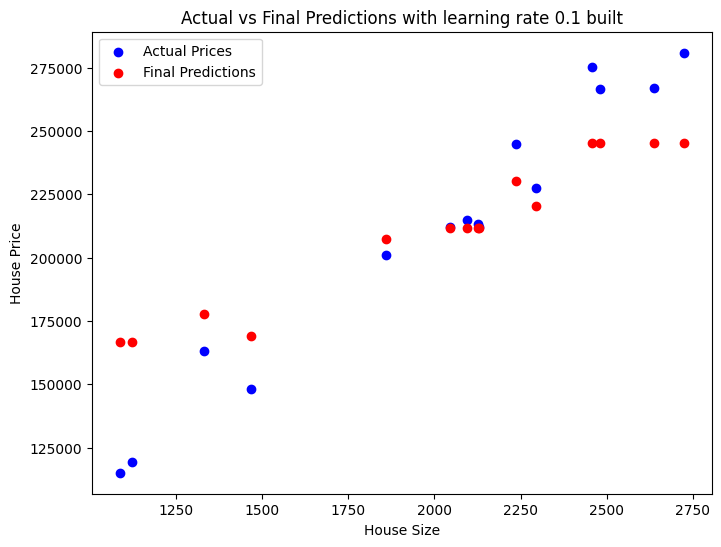

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Create a small dataset with 3 features
np.random.seed(42)
n_sample = 15
house_size = np.random.randint(1000, 3000, n_sample)  # House size in sq ft
num_bedrooms = np.random.randint(2, 5, n_sample)  # Number of bedrooms
year_built = np.random.randint(1980, 2022, n_sample)  # Year built
house_price = (house_size * 100 + num_bedrooms * 5000 + (2022 - year_built) * (-200) + np.random.normal(0, 10000, n_sample))  # House price

# Create DataFrame
df = pd.DataFrame({"House Size": house_size, "Num Bedrooms": num_bedrooms, "Year Built": year_built, "House Price": house_price})
print("Original Dataset:")
print(df)

# Extract features and target
X = df[["House Size", "Num Bedrooms", "Year Built"]]
y = df["House Price"]

# Initialize predictions with mean
y_pred_0 = np.full(shape=y.shape, fill_value=np.mean(y))

# Compute residuals (errors from initial predictions)
residuals_0 = y - y_pred_0

df["Prediction"] = y_pred_0
df["Residual"] = df["House Price"] - df["Prediction"]

print(df)

# Calculate gain to find the best split
def compute_gain(feature, threshold, X, residuals, lambda_reg=1, gamma=0):
    """Computes the gain for a potential split."""
    left_idx = X[feature] <= threshold
    right_idx = ~left_idx

    G_L = residuals[left_idx].sum()
    G_R = residuals[right_idx].sum()
    H_L = len(residuals[left_idx])
    H_R = len(residuals[right_idx])

    gain = 0.5 * ((G_L**2 / (H_L + lambda_reg)) + (G_R**2 / (H_R + lambda_reg)) - ((G_L + G_R)**2 / (H_L + H_R + lambda_reg))) - gamma
    return gain

# Compute gains for different splits
thresholds = {col: np.percentile(X[col], [25, 50, 75]) for col in ["House Size", "Num Bedrooms", "Year Built"]}
gains = [(feature, threshold, compute_gain(feature, threshold, X, residuals_0)) 
         for feature, values in thresholds.items() for threshold in values]

# Select best split (feature & threshold with highest gain)
best_feature, best_threshold, best_gain = max(gains, key=lambda x: x[2])
print(f"Best Split: Feature = {best_feature}, Threshold = {best_threshold}, Gain = {best_gain:.2f}")

# 5Train XGBoost model step by step
tree_1 = XGBRegressor(n_estimators=1, max_depth=3, learning_rate=1, objective="reg:squarederror")
tree_1.fit(X, residuals_0)
residuals_pred_1 = tree_1.predict(X)

# Update predictions using first tree
learning_rate = 0.1
y_pred_1 = y_pred_0 + learning_rate * residuals_pred_1

df["Prediction_1"] = y_pred_1
df["Residual_1"] = df["House Price"] - df["Prediction"]

print(df)

# Train full XGBoost model
xgb_model = XGBRegressor(n_estimators=10, max_depth=3, learning_rate=0.1, objective="reg:squarederror")
xgb_model.fit(X, y)

# Predict & evaluate
y_pred_final = xgb_model.predict(X)
mse = mean_squared_error(y, y_pred_final)
print(f"Final Mean Squared Error: {mse:.2f}")

# Visualization
# Scatter plot of actual vs predicted values
# Final comparison
plt.figure(figsize=(8, 6))
plt.scatter(df["House Size"], df["House Price"], color='blue', label='Actual Prices')
plt.scatter(df["House Size"], y_pred_final, color='red', label='Final Predictions')
plt.xlabel("House Size")
plt.ylabel("House Price")
plt.title(f"Actual vs Final Predictions with learning rate {learning_rate} built")
plt.legend()
plt.show()